# Get city outline 

### Prerequisites: 
- get ocean shapefile [here](https://www.naturalearthdata.com/downloads/10m-physical-vectors/10m-ocean/)



### Steps
1. get city bounds
    - optionally search for existing waterbodies in the  area
2. convert that to utm
4. convert to polygons
5. write polygons to geojson

In [26]:
# import helper functions 

# add helper function location
import sys 
sys.path.append('../../functions')

import helpers

from importlib import reload  
reload(helpers)

<module 'helpers' from '../../functions/helpers.py'>

In [27]:
# geospatial operations on points, polygons, polylines (e.g. shapes) 
import shapely

# shapely function to create shapely object from GeoJSON
from shapely.geometry import shape, Polygon

# plotting tools 
import folium

# OSM api
import overpass


## dealing with files
# we use fiona to read shapefiles
import fiona
# we use ogr to write shapefiles
# from osgeo import ogr

import matplotlib.pyplot as plt


from shapely.ops import cascaded_union
from shapely.geometry import MultiPolygon, Polygon, Point, MultiPoint
from itertools import chain

from shapely.ops import transform
from shapely import ops
from functools import partial
import pyproj

from shapely.ops import cascaded_union, unary_union
from shapely.affinity import translate
import fiona

import fiona
from shapely.geometry import shape, MultiPolygon, Polygon
import glob
import geopandas

import os

from geopy.geocoders import Nominatim


## Define parameters

In [30]:
search_water = True
plot_shapes = True

data_path = '../../data'

ocean_shape_file_path = '../../data/ne_10m_ocean/'

output_path = '../../data/city_outline/'

country_name = 'Indonesia'

cities = ['Jakarta']

In [31]:
# check if directories exist otherwise create them

helpers.make_dir(data_path)
helpers.make_dir(ocean_shape_file_path)
helpers.make_dir(output_path)

Directory  ../../data  Created
Directory  ../../data/ne_10m_ocean/  Created
Directory  ../../data/city_outline/  Created


# Get ocean

In [34]:

# Read polygons from file and apply as gee geometries
import wget

cwd = os.getcwd()

# find files in shapefile folder

shape_files = glob.glob(ocean_shape_file_path + '*.shp')

# download shape if not found


if len(shape_files) == 0:

    print('file not available, initiate download')
    
    url = "https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/physical/ne_10m_ocean.zip"

    from zipfile import ZipFile

    import wget

    ocean_zip_file_path = wget.download(url, ocean_shape_file_path + url.split('/')[-1])


    with ZipFile(ocean_zip_file_path, 'r') as zipObj:
       # Extract all the contents of zip file in current directory
       zipObj.extractall(path = ocean_shape_file_path)

Directory  ../../data/ne_10m_ocean/  already exists...
Directory  ../../data/city_outline/  already exists...
file not available, initiate download


In [35]:
shape_files = glob.glob(ocean_shape_file_path + '*.shp')

if len(shape_files) > 0:
    print('file available, load shapefile')

    path = shape_files[0]

    shp_ocean = [shape(pol['geometry']) for pol in fiona.open(path)][0]
    shp_ocean = shp_ocean.simplify(0.0001)
    id_list = [pol['id'] for pol in fiona.open(path)]

    cwd, shape_files, path

file available, load shapefile


# Get city

833 waterpolygons found


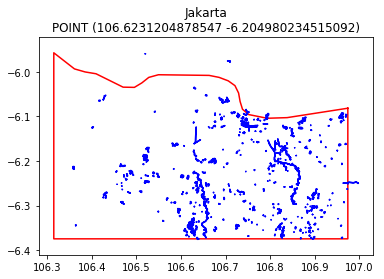

In [36]:
shp_list_cities = []
shp_list_water = []
id_list_water = []

# initiate overpass API
api = overpass.API()

# for city in cities:

city_name = cities[0]

# sigle
if type(city_name) == str:
    app = Nominatim(user_agent="rimbunio")
    # get location raw data
    location = app.geocode(city_name).raw
    bbox = [float(i) for i in location['boundingbox']]
    ymin, ymax, xmin, xmax = bbox
    shp_city_ox = [Polygon(shapely.geometry.box(xmin, ymin, xmax, ymax, ccw=True))]
    
    
# multiple cities
else:
    city_query = []
    for city in city_name:
        city_query.append('{}, {}'.format(city, country_name))
        
    ox_city = ox.gdf_from_places(city_query)
    shp_city_ox = ox_city.geometry

shp_city_list = []

for shp in shp_city_ox: 
    
    shp_city_list.append(shp)
    
try:
    shp_city = cascaded_union(shp_city_list[0])
except Exception as e:
    print(e)
    print('no union needed')
    
try:
    shp_city_land = shp_city.difference(shp_ocean)
except Exception as e:
    print(e)
    shp_city_land = shp_city

try: 
    len(shp_city_land)
    x,y = shp_city_land[0].exterior.xy
except:
    x,y = shp_city_land.exterior.xy


shp_list_cities.append(shp_city_land)


if search_water:

    # get bounding box
    x_w, y_s, x_e, y_n = shp_city_land.bounds

    # get water
    # create a Query
    query_way = 'way["natural"="water"]({0},{1},{2},{3});(._;>;)'.format(y_s, x_w, y_n, x_e)
    query_relation = 'relation["natural"="water"]({0},{1},{2},{3});(._;>;)'.format(y_s, x_w, y_n, x_e)

    # ["waterway"!="riverbank"]["water"!="river"]
    try:
        response_way = api.get(query_way, responseformat="geojson", verbosity='geom')
        response_relation = api.get(query_relation, responseformat="geojson", verbosity='geom')
        OSM_data = [f for f in chain(response_way.features, response_relation.features) if (f.geometry['type'] == "LineString" and len(f.geometry['coordinates']) > 2)]

        shp_water = MultiPolygon([Polygon(shape(pol['geometry'])) for pol in OSM_data]) 
        id_list = [pol['id'] for pol in OSM_data]

        id_list_water.append(id_list)
        shp_list_water.append(shp_water)

        print(str(len(shp_water)) + ' waterpolygons found')
    except Exception as e:
        print(e)
        print('no water found')

if plot_shapes:
    
    plt.plot(x,y, color = 'r')
    
    if search_water:
        for water in shp_list_water[0]:
            x,y = water.boundary.xy
            plt.plot(x,y, color = 'b')
        
    
    
    plt.axis('equal')
    plt.title(str(city_name) + '\n' + str(shp_city_land.centroid))

    plt.show()

In [38]:
# check if data makes sense by plotting it

m = folium.Map((location['lat'], location['lon']), zoom_start=10)


folium.Choropleth(shp_city_ox[0]).add_to(m)
folium.Choropleth(shp_city_land).add_to(m)

for shape in shp_list_water[0]:
    folium.Choropleth(shape).add_to(m)

folium.CircleMarker(location=(location['lat'], location['lon'])).add_to(m)

m

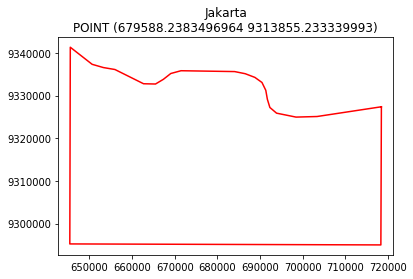

In [39]:
import warnings
warnings.filterwarnings('ignore')

x,y = shp_city_land.boundary.xy
epsg = wgs2epsg(x[0], y[0])

#  EPSG:32748 is also known as WGS 84 / UTM zone 48S

# set projections
project_wgs2utm = partial(
    pyproj.transform,
    pyproj.Proj(init='epsg:4326'),
    pyproj.Proj(init='epsg:{}'.format(epsg)))

project_utm2wgs = partial(
    pyproj.transform,
    pyproj.Proj(init='epsg:{}'.format(epsg)), # from
    pyproj.Proj(init='epsg:4326'))            # to

shp_city_land_utm = transform(project_wgs2utm, shp_city_land)


x,y = shp_city_land_utm.exterior.xy
plt.plot(x,y,color = 'r')
plt.axis('equal')

plt.title(str(city_name) + '\n' + str(shp_city_land_utm.centroid))

plt.show()

In [40]:
# write shape to file
geojson_poly = geopandas.GeoSeries([shp_city_land]).__geo_interface__

gdf = geopandas.GeoDataFrame.from_features(geojson_poly)

gdf.to_file("../../data/city_outline/{}_wgs.geojson".format(city_name), driver='GeoJSON')